# Compare the results for Scanpro with/without replicates

In [1]:
import pandas as pd
import numpy as np
import multiprocessing as mp
import time
import seaborn as sns
import matplotlib.pyplot as plt

from scanpro import scanpro

In [2]:
def monitor_jobs(jobs):
    """
    Monitor the status of jobs submitted to a pool.

    Parameters
    ----------
    jobs : list of job objects
        List of job objects, e.g. as returned by pool.map_async().
    """

    if isinstance(jobs, dict):
        jobs = list(jobs.values())

    from tqdm import tqdm_notebook as tqdm
    pbar = tqdm(total=len(jobs))
    
    # Wait for all jobs to finish
    n_ready = sum([job.ready() for job in jobs])
    while n_ready != len(jobs):
        if n_ready != pbar.n:
            pbar.n = n_ready
            pbar.refresh()
        time.sleep(1)
        n_ready = sum([job.ready() for job in jobs])

    pbar.n = n_ready  # update progress bar to 100%
    pbar.refresh()
    pbar.close()

In [3]:
def convert_counts_to_df(counts, prop_cols=None, meta_cols=None, n_cells=1, column_name="Cluster"):
    """ Convert a cell count matrix to a dataframe in long format."""

    counts = counts.copy()

    #If not given, try to get prop_cols and meta_cols automatically
    if prop_cols is None:
        dtypes = counts.dtypes.astype(str)
        prop_cols = [col for i, col in enumerate(counts.columns) if "float" in dtypes[i] or "int" in dtypes[i]]
        
    if meta_cols is None:
        meta_cols = [col for col in counts.columns if col not in prop_cols]

    # Multiply proportions with n_cells
    counts[prop_cols] *= n_cells
    counts[prop_cols] = counts[prop_cols].astype(int)
    
    # Melt into long format (similar to adata.obs)
    counts_melt = pd.melt(counts, id_vars=meta_cols, value_vars=prop_cols, 
                          var_name=column_name, value_name="count")

    # Duplicate rows based on number of cells
    counts_long = counts_melt.loc[counts_melt.index.repeat(counts_melt["count"])].reset_index(drop=True)
    counts_long.drop(columns="count", inplace=True)
    counts_long.index = ["cell_" + str(i) for i in range(1, len(counts_long) + 1)]
    
    return counts_long

--------

# Read data

In [4]:
pbmc_counts = pd.read_csv("data/pbmc_counts.tsv", sep="\t")
pbmc = convert_counts_to_df(pbmc_counts, column_name="Celltype")

In [5]:
heart_counts = pd.read_csv("data/heart_counts.tsv", sep="\t")
heart = convert_counts_to_df(heart_counts, column_name="Celltype")

In [6]:
fetal_scatac_counts = pd.read_csv("data/scATAC_counts.tsv", sep="\t")
fetal_scatac = convert_counts_to_df(fetal_scatac_counts, column_name="Celltype")

In [7]:
covid_counts = pd.read_csv("data/covid_counts.tsv", sep="\t")
covid = convert_counts_to_df(covid_counts, column_name="Celltype")

-----------

# Run normal and bootstrap runs

In [8]:
def run_bootstrap(dataset, clusters_col, conds_col, **kwargs):
    
    pool = mp.Pool(30)
    
    # Run Scanpro with bootstrapping with 100 different seeds
    jobs = []
    for seed in range(100):
        job = pool.apply_async(scanpro.scanpro, (dataset,), dict(clusters_col=clusters_col, conds_col=conds_col, 
                                                                 transform='arcsin', seed=seed, verbosity=0, **kwargs))
        jobs.append(job)
    pool.close()

    monitor_jobs(jobs)

    results = [job.get() for job in jobs]
    pool.join()
    
    #Add seed column to each result
    for seed in range(len(results)):
        results[seed].results.insert(0, "seed", seed)
        
    # Collect result
    all_run_results = pd.concat([result.results for result in results])
    
    return all_run_results

## PBMC

In [9]:
pbmc_results = scanpro.scanpro(pbmc, clusters_col='Celltype', conds_col='Sex', samples_col="Sample")

[INFO] There are 2 conditions. T-Test will be performed...
[INFO] Done!


In [10]:
pbmc_norep_results = run_bootstrap(pbmc, clusters_col='Celltype', conds_col='Sex')

  0%|          | 0/100 [00:00<?, ?it/s]

## Heart

In [11]:
heart_results = scanpro.scanpro(heart, clusters_col='Celltype', conds_col='Condition', samples_col="Sample")

[INFO] There are more than 2 conditions. ANOVA will be performed...
[INFO] Done!


In [12]:
heart_norep_results = run_bootstrap(heart, clusters_col='Celltype', conds_col='Condition')

  0%|          | 0/100 [00:00<?, ?it/s]

## Fetal scATAC

In [13]:
scatac_results = scanpro.scanpro(fetal_scatac, clusters_col='Celltype', conds_col='tissue', samples_col="sample_name", 
                                 conditions=['heart', 'muscle'])

[INFO] There are 2 conditions. T-Test will be performed...
[INFO] Done!


In [14]:
scatac_norep_results = run_bootstrap(fetal_scatac, clusters_col='Celltype', conds_col='tissue', 
                                    conditions=['heart', 'muscle'])

  0%|          | 0/100 [00:00<?, ?it/s]

## Covid

In [15]:
covid_results = scanpro.scanpro(covid, clusters_col='Celltype', conds_col='group', samples_col="sample")

[INFO] There are more than 2 conditions. ANOVA will be performed...
[INFO] Done!


In [16]:
covid_norep_results = run_bootstrap(covid, clusters_col='Celltype', conds_col='group')

  0%|          | 0/100 [00:00<?, ?it/s]

----------

# Compare runs per dataset

In [17]:
data = {"pbmc": {"rep": pbmc_results.results,
                 "norep": pbmc_norep_results},
        "heart": {"rep": heart_results.results,
                  "norep": heart_norep_results},
        "scatac": {"rep": scatac_results.results,
                   "norep": scatac_norep_results},
        "covid": {"rep": covid_results.results,
                  "norep": covid_norep_results}}
        
plot_titles = {"pbmc": "PBMC male vs. female",
               "heart": "Heart development",
               "scatac": "Fetal scATAC cell atlas",
               "covid": "Covid-19"}

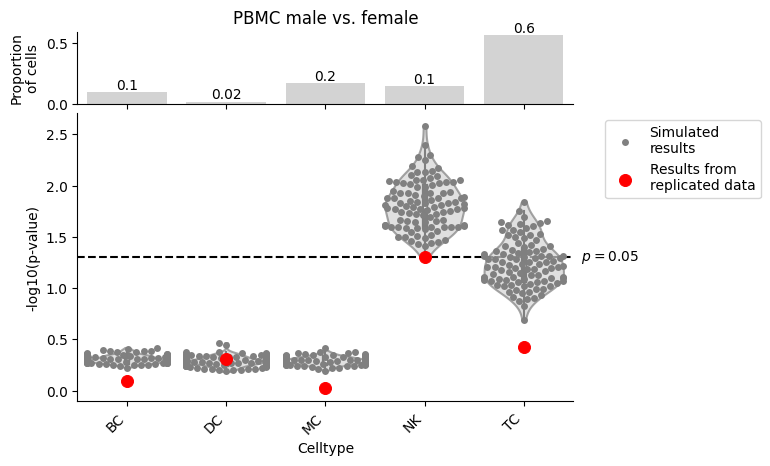

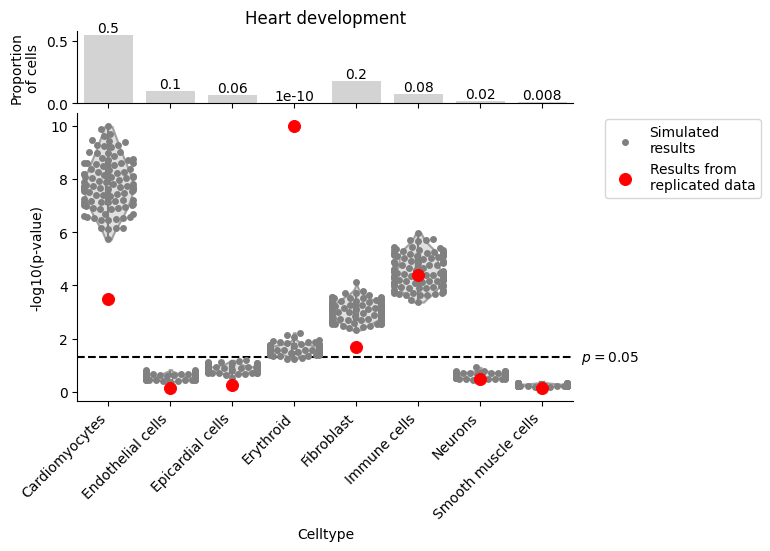

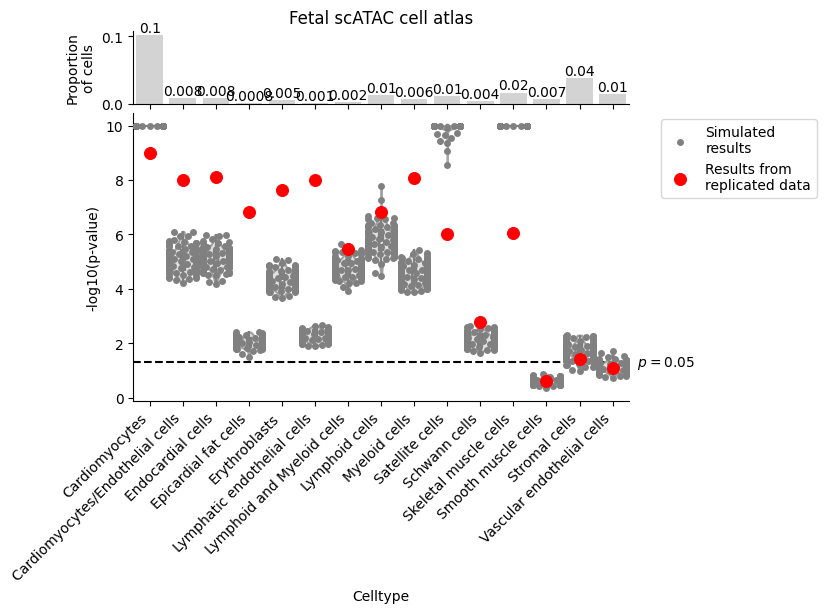

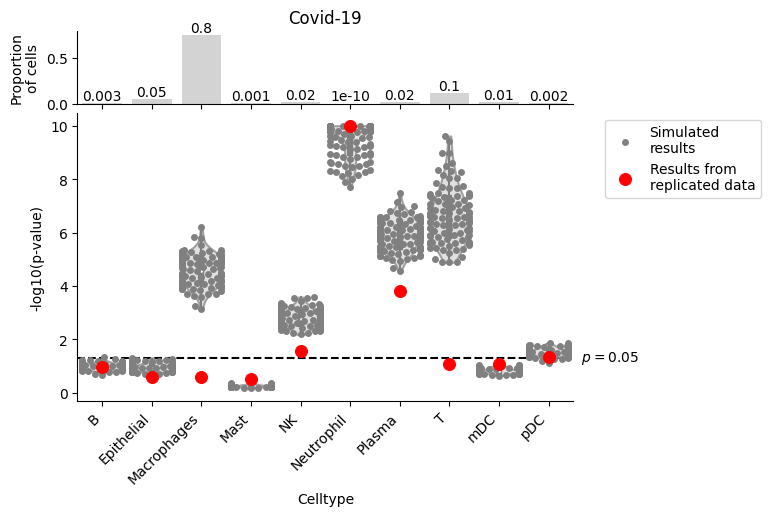

In [18]:
for dataset in data:
    
    # Prepare data
    data_norep = data[dataset]["norep"].copy()
    data_rep = data[dataset]["rep"].copy()
    
    data_norep[data_norep.iloc[:,-1] < 10**-10] = 10**-10
    data_rep[data_rep.iloc[:,-1] < 10**-10] = 10**-10
    
    data_norep["-log10(p-value)"] = -np.log10(data_norep.iloc[:,-1])
    data_rep["-log10(p-value)"] = -np.log10(data_rep.iloc[:,-1])
    
    index_name = data_norep.index.name
    data_norep.reset_index(inplace=True)
    data_rep.reset_index(inplace=True)

    # Prepare plot
    fig, axarr = plt.subplots(2, sharex=True, height_ratios=[0.2,0.8])
    plt.subplots_adjust(hspace=0.05)
    
    for ax in axarr:
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
    ax = axarr[0]
    
    # Add title to plot
    ax.set_title(plot_titles.get(dataset, ""))

    # Add proportion on top
    ax = axarr[0]
    sns.barplot(data=data_rep, x=index_name, y="baseline_props", ax=ax, color="lightgrey")
    ax.set_xlabel("")
    ax.set_ylabel("Proportion\nof cells")
    ax.bar_label(ax.containers[0], fmt='%.g')

    # Plot results of simulated run
    ax = axarr[1]
    sns.violinplot(data_norep, x=index_name, y="-log10(p-value)", 
                        cut=0, scale="width", color="lightgrey", ax=ax)
    for violin in ax.collections[::2]:
        violin.set_alpha(0.7)
        
    
    sns.swarmplot(data_norep, x=index_name, y="-log10(p-value)", label="Simulated\nresults", color="grey", ax=ax)

    # Plot results of replicated data
    xlim = ax.get_xlim()
    sns.scatterplot(data=data_rep, x=index_name, y="-log10(p-value)", label="Results from\nreplicated data", 
                    color="red", zorder=100, ax=ax, legend=True, s=75, lw=0, edgecolor = None)
    ax.set_xlim(xlim)
    
    # Plot threshold line
    pvalue_threshold = -np.log10(0.05)
    ax.axhline(pvalue_threshold, zorder=0, color="black", ls="--")
    ax.text(ax.get_xlim()[1], pvalue_threshold, "  $\it{p=0.05}$", va="center")
    
    # Remove duplicates entries in legend
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[-2:], labels[-2:], loc="upper left", bbox_to_anchor=(1.05,1))
    
    # Set xticklabels
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    
    plt.savefig(f"plots/{dataset}_bootstrap_comparison.pdf", dpi=300, bbox_inches="tight")
    plt.show()